The datasets `ADNI1_Complete_3Yr_1.5T` and `ADNI1_Complete_3Yr_3T` have been selected for the project but they contain some duplicate subjects between them so we need to inspect them to decide how to proceed. We will:
- Check if the `nii` files are duplicates for the same subject (compare dates, IDs and descriptions)
- Decide which files to keep

### Load the data

In [1]:
import pandas as pd

df3t = pd.read_csv(r'~/ADNI_data/ADNI1_Complete_3Yr_3T_4_08_2024.csv')
df15t = pd.read_csv(r'~/ADNI_data/ADNI1_Complete_3Yr_1.5T_4_08_2024.csv')

print("Shape of 3T data", df3t.shape)
print("Shape of 1.5T data", df15t.shape)

Shape of 3T data (347, 12)
Shape of 1.5T data (1693, 12)


Drop unneccessary columns

In [2]:
df3t.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I119733,136_S_0429,MCI,M,63,bl,MRI,MPR; ; N3; Scaled_2,Processed,6/27/2006,NiFTI,NaN
1,I88169,136_S_0429,MCI,M,64,m18,MRI,MPR; ; N3; Scaled,Processed,12/17/2007,NiFTI,NaN
2,I66801,136_S_0429,MCI,M,63,m06,MRI,MPR; ; N3; Scaled,Processed,12/18/2006,NiFTI,NaN
3,I205562,136_S_0429,MCI,M,66,m36,MRI,MPR; ; N3; Scaled,Processed,7/13/2009,NiFTI,NaN
4,I83549,136_S_0429,MCI,M,64,m12,MRI,MPR; ; N3; Scaled,Processed,6/18/2007,NiFTI,NaN


In [3]:
df15t.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I204843,941_S_1202,CN,M,81,m36,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/14/2010,NiFTI,NaN
1,I137298,941_S_1202,CN,M,80,m24,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/17/2009,NiFTI,NaN
2,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN
3,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN
4,I75141,941_S_1194,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/22/2007,NiFTI,NaN


### Keep only the corresponding 1.5T data we have

In [4]:
import os
from pathlib import Path

print('Before filtering')
print('Number of 1.5T images:', df15t['Image Data ID'].nunique())
print('Number of 1.5T subjects:', df15t.Subject.nunique())

raw_data_dir = r'/home/nacer/ADNI_data/ADNI1_Complete_3Yr/raw_data'
# existing_image_ids = []
# for folder, dirs, filenames in os.walk(Path(raw_data_dir)):
#     dirname = Path(folder).name
#     if dirname.startswith('I'):
#         existing_image_ids.append(dirname)

# df15t = df15t[df15t['Image Data ID'].isin(existing_image_ids)]

print('\nAfter filtering')
print('Number of 1.5T images:', df15t['Image Data ID'].nunique())
print('Number of 1.5T subjects:', df15t.Subject.nunique())

Before filtering
Number of 1.5T images: 1693
Number of 1.5T subjects: 382

After filtering
Number of 1.5T images: 1693
Number of 1.5T subjects: 382


### Drop unneccessary columns

In [5]:
cols_to_drop = ['Modality', 'Downloaded', 'Type', 'Format', 'Sex', 'Age']
df3t.drop(columns=cols_to_drop, inplace=True)
df15t.drop(columns=cols_to_drop, inplace=True)

print("Shape of 3T data", df3t.shape)
print("Shape of 1.5T data", df15t.shape)

Shape of 3T data (347, 6)
Shape of 1.5T data (1693, 6)


### Concatenate the dataframes

In [6]:
df15t['T'] = '1.5T'
df3t['T'] = '3T'
df = pd.concat([df15t, df3t]).sort_values(['Subject', 'Acq Date'])
df['Acq Date'] = pd.to_datetime(df['Acq Date'])

print('Number of images:', df['Image Data ID'].nunique())
print('Number of subjects:', df.Subject.nunique())
print('Shape: ', df.shape)

Number of images: 2040
Number of subjects: 397
Shape:  (2040, 7)


### The checks

Check if the scans that have the same date also have the same image id and compare the descriptions

In [7]:
df[df.duplicated('Image Data ID')]

,Image Data ID,Subject,Group,Visit,Description,Acq Date,T


Every image has a unique ID. So we should inspect the descriptions

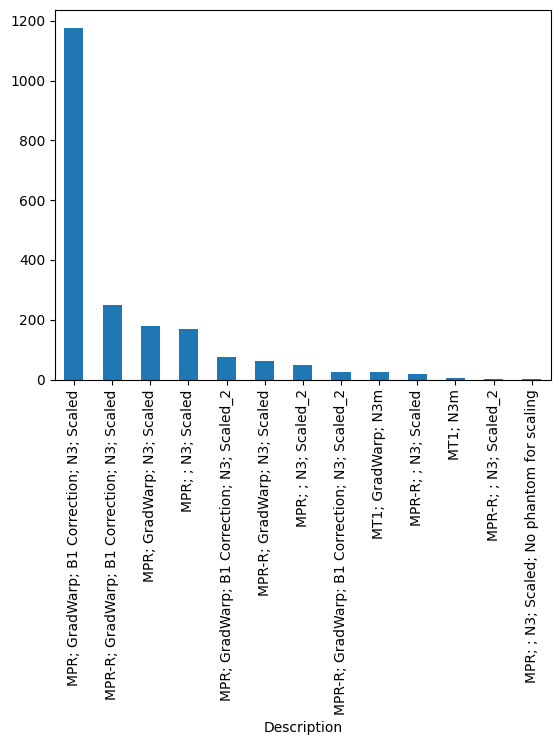

In [8]:
import matplotlib.pyplot as plt

df.Description.value_counts().plot(kind='bar')
plt.show()

In [9]:
# Drop the images with descriptions ending with '2' as well as non 'MPR' or 'MPR-R' ones
descripions_to_drop_mask = df['Description'].str.endswith('2') | (~df['Description'].str.startswith('MPR'))
print('Number of images dropped: ', descripions_to_drop_mask.sum())
df = df[~descripions_to_drop_mask]

Number of images dropped:  183


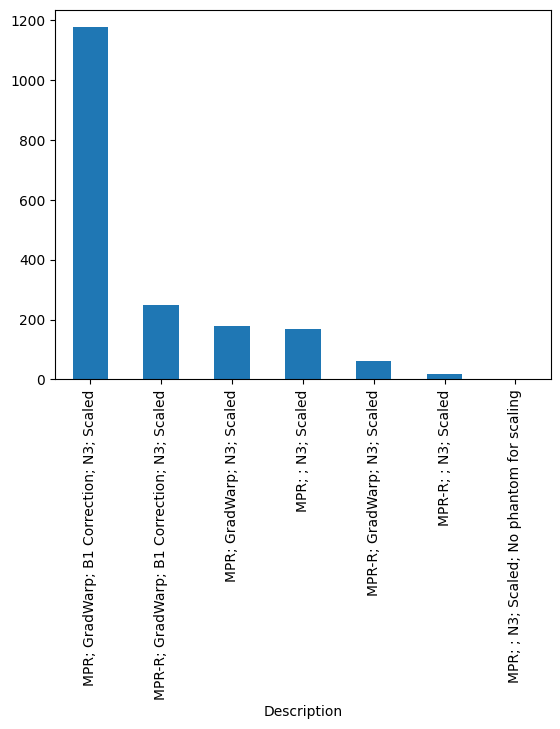

In [10]:
df.Description.value_counts().plot(kind='bar')
plt.show()

In [11]:
print('Shape:', df.shape)
print('Number of images:', df['Image Data ID'].nunique())
print('Number of subjects:', df.Subject.nunique())

Shape: (1857, 7)
Number of images: 1857
Number of subjects: 397


#### Check the image counts

In [12]:
# Number of images per subject by magnetic field strength (T)
image_counts_per_subject_by_T = df.pivot_table(values='Image Data ID', index='Subject', aggfunc='count', columns='T')
image_counts_per_subject_by_T.describe().convert_dtypes()

T,1.5T,3T
count,382.0,60.0
mean,4.089005,4.916667
std,0.814846,0.907439
min,2.0,3.0
25%,3.0,4.0
50%,4.0,5.0
75%,5.0,6.0
max,5.0,6.0


In [13]:
# Number of images per subject by visit
image_counts_per_subject_by_visit = df.pivot_table(
    values='Image Data ID',
    index='Subject',
    aggfunc='count',
    columns='Visit',
    fill_value=0
)
image_counts_per_subject_by_visit.describe().convert_dtypes()

Visit,bl,m06,m12,m18,m24,m36,nv
count,397.0,397.0,397.0,397.0,397.0,397.0,397.0
mean,0.146096,1.098237,1.110831,0.423174,1.110831,0.785894,0.002519
std,0.353648,0.33017,0.314319,0.561624,0.322253,0.570311,0.050189
min,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,1.0,1.0,0.0,1.0,0.0,0.0
50%,0.0,1.0,1.0,0.0,1.0,1.0,0.0
75%,0.0,1.0,1.0,1.0,1.0,1.0,0.0
max,1.0,2.0,2.0,2.0,2.0,2.0,1.0


In [14]:
num_duplicated_visits = df.duplicated(['Subject', 'Visit']).sum()
print(f'There are {num_duplicated_visits} total duplicate combinations of subjects and visits')
num_duplicated_visits = df.duplicated(['Subject', 'Acq Date']).sum()
print(f'There are {num_duplicated_visits} total duplicate combinations of subjects and dates')

There are 177 total duplicate combinations of subjects and visits
There are 123 total duplicate combinations of subjects and dates


- Some subjects have duplicated visits with the images having same or different dates in those visits
- Only same-day images are going to be considered as duplicated
- One way to address this is by keeping only the image that went through more standardization steps (longer description)

In [15]:
# Sort the duplicated visit images by description (longer description goes to the bottom)
df = df.sort_values(['Subject', 'Visit', 'Acq Date', 'Description'])
# Set the index for a clearer view of the hierarchy
df[df.duplicated(['Subject', 'Visit', 'Acq Date'], keep=False)]\
  .set_index(["Subject", "Visit", "Acq Date", "Group"])\
  .head(100)

Image Data ID  \
Subject    Visit Acq Date   Group                 
002_S_0413 m12   2007-06-01 CN           I64551   
                            CN           I60008   
           m24   2008-07-31 CN          I120746   
                            CN          I120917   
002_S_1018 m12   2007-12-07 AD           I97022   
...                                         ...   
023_S_0625 m18   2008-01-11 MCI          I90880   
           m36   2009-10-20 MCI         I218559   
                            MCI         I162301   
023_S_0916 m06   2007-04-24 AD           I87302   
                            AD           I64827   

                                                                Description  \
Subject    Visit Acq Date   Group                                             
002_S_0413 m12   2007-06-01 CN                            MPR; ; N3; Scaled   
                            CN     MPR; GradWarp; B1 Correction; N3; Scaled   
           m24   2008-07-31 CN                            MPR; ; N3; Scaled   
                            CN     MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_1018 m12   2007-12-07 AD                            MPR; ; N3; Scaled   
...                                                                     ...   
023_S_0625 m18   2008-01-11 MCI    MPR; GradWarp; B1 Correction; N3; Scaled   
           m36   2009-10-20 MCI    MPR; GradWarp; B1 Correction; N3; Scaled   
                            MCI    MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0916 m06   2007-04-24 AD     MPR; GradWarp; B1 Correction; N3; Scaled   
                            AD     MPR; GradWarp; B1 Correction; N3; Scaled   

                                      T  
Subject    Visit Acq Date   Group        
002_S_0413 m12   2007-06-01 CN       3T  
                            CN     1.5T  
           m24   2008-07-31 CN       3T  
                            CN     1.5T  
002_S_1018 m12   2007-12-07 AD       3T  
...                                 ...  
023_S_0625 m18   2008-01-11 MCI    1.5T  
           m36   2009-10-20 MCI    1.5T  
                            MCI      3T  
023_S_0916 m06   2007-04-24 AD     1.5T  
                            AD       3T  

[100 rows x 3 columns]

In [16]:
# Drop duplicated images keeping the last one (the longer description after sorting)
df = df.drop_duplicates(["Subject", "Visit", 'Acq Date'], keep='last')
df.set_index(["Subject", "Visit", "Acq Date", "Group"]).head(30)

Image Data ID  \
Subject    Visit Acq Date   Group                 
002_S_0295 m06   2006-11-02 CN           I40966   
           m12   2007-05-25 CN           I64025   
           m24   2008-07-23 CN          I123685   
           m36   2009-05-22 CN          I150177   
002_S_0413 bl    2006-05-19 CN           I40657   
           m06   2006-11-15 CN           I79122   
           m12   2007-06-01 CN           I60008   
           m24   2008-07-31 CN          I120917   
           m36   2009-04-30 CN          I149735   
                 2009-05-04 CN          I149740   
002_S_0559 bl    2006-06-27 CN           I45126   
           m06   2006-12-12 CN           I79123   
           m12   2007-10-18 CN           I82102   
           m24   2008-08-15 CN          I120779   
           m36   2009-06-30 CN          I171087   
002_S_0619 m06   2006-12-13 AD           I60451   
           m12   2007-06-22 AD           I67871   
           m24   2008-08-13 AD          I120964   
002_S_0685 m06   2007-01-22 CN           I86020   
           m12   2007-08-02 CN           I74174   
           m24   2008-08-22 CN          I120994   
           m36   2009-07-21 CN          I161974   
002_S_0729 m06   2007-02-22 MCI          I64741   
           m12   2007-09-05 MCI          I78654   
           m18   2008-04-03 MCI         I121067   
           m24   2008-09-29 MCI         I123994   
           m36   2009-08-13 MCI         I171092   
002_S_0782 m06   2007-04-11 MCI          I60456   
           m12   2007-09-19 MCI          I87283   
           m18   2008-06-18 MCI         I112184   

                                                                  Description  \
Subject    Visit Acq Date   Group                                               
002_S_0295 m06   2006-11-02 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m12   2007-05-25 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m24   2008-07-23 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m36   2009-05-22 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_0413 bl    2006-05-19 CN                              MPR; ; N3; Scaled   
           m06   2006-11-15 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m12   2007-06-01 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m24   2008-07-31 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m36   2009-04-30 CN                              MPR; ; N3; Scaled   
                 2009-05-04 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_0559 bl    2006-06-27 CN                              MPR; ; N3; Scaled   
           m06   2006-12-12 CN                              MPR; ; N3; Scaled   
           m12   2007-10-18 CN                            MPR-R; ; N3; Scaled   
           m24   2008-08-15 CN                              MPR; ; N3; Scaled   
           m36   2009-06-30 CN                              MPR; ; N3; Scaled   
002_S_0619 m06   2006-12-13 AD                      MPR; GradWarp; N3; Scaled   
           m12   2007-06-22 AD                    MPR-R; GradWarp; N3; Scaled   
           m24   2008-08-13 AD       MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_0685 m06   2007-01-22 CN     MPR-R; GradWarp; B1 Correction; N3; Scaled   
           m12   2007-08-02 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m24   2008-08-22 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m36   2009-07-21 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_0729 m06   2007-02-22 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
           m12   2007-09-05 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
           m18   2008-04-03 MCI    MPR-R; GradWarp; B1 Correction; N3; Scaled   
           m24   2008-09-29 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
           m36   2009-08-13 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_0782 m06   2007-04-11 MCI      MPR; GradWarp; 

In [17]:
df.pivot_table(
    values='Image Data ID',
    index='Subject',
    aggfunc='count',
    columns='Acq Date',
    fill_value=0
).max().max()

1

In [18]:
print('Shape:', df.shape)
print('Number of images:', df['Image Data ID'].nunique())
print('Number of subjects:', df.Subject.nunique())

Shape: (1734, 7)
Number of images: 1734
Number of subjects: 397


Now every subject has at most one image per date (but possibly multiple images per visit)

### Class Imbalance

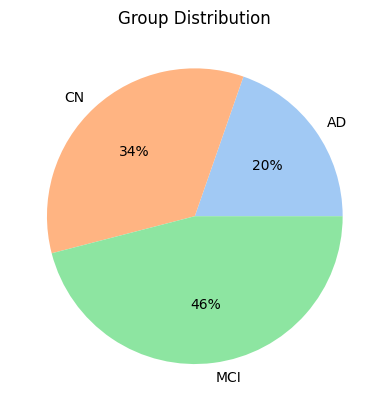

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

subject_group_pivot = df.pivot_table(values='Image Data ID', index='Subject', columns='Group', aggfunc='count')
group_counts = subject_group_pivot.sum()
plt.pie(group_counts, labels=group_counts.index, autopct='%.0f%%', colors=sns.color_palette('pastel'))
plt.title('Group Distribution')
plt.show()

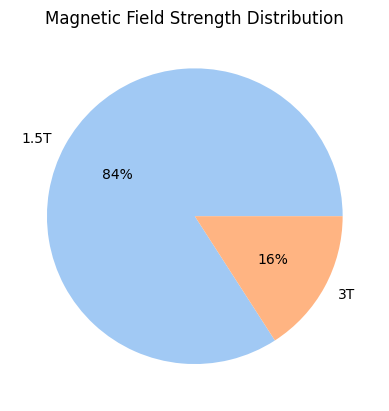

In [20]:
T_counts = image_counts_per_subject_by_T.sum()
plt.pie(T_counts, labels=T_counts.index, autopct='%.0f%%', colors=sns.color_palette('pastel'))
plt.title('Magnetic Field Strength Distribution')
plt.show()

In [23]:

# Distribution of image counts among the subjects
# image_counts_per_subject_by_visit.iloc[:, :-2]\
#     .replace(0, pd.NA)\
#     .apply('sum', axis=1)\
#     .value_counts()\
#     .sort_index()\
#     .plot(kind='bar')
# plt.xlabel('Image Count')
# plt.ylabel('Subject Count')
# plt.title('Distribution of subjects by image count')
# plt.show()

# Add the group column
image_counts_per_subject = image_counts_per_subject_by_visit.apply('sum', axis=1).rename('Image Count').to_frame()
image_counts_per_subject = image_counts_per_subject.merge(
    subject_group_pivot.idxmax(axis=1).rename('Group'),
    right_index=True,
    left_index=True
)
subject_count_per_image_count_by_group = image_counts_per_subject\
    .reset_index()\
    .pivot_table(
        index='Image Count',
        values='Subject',
        columns='Group',
        aggfunc='count',
        fill_value=0
    )
subject_count_per_image_count_by_group

Group,AD,CN,MCI
Image Count,,,
2,4,0,0
3,82,3,0
4,3,114,8
5,0,6,127
6,1,0,5
7,13,2,0
8,0,1,0
9,0,14,0
11,0,0,14


### Save the final image IDs for preprocessing

In [25]:
# Save the subject diagnosis labels for later use
subject_group_pivot.idxmax(axis=1).rename('Group').value_counts().to_csv('subject_groups.csv')
# Save the images ids
df['Image Data ID'].to_csv('final_image_ids.csv', index=False)